In [467]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py
from skimage import color

In [468]:
def qpie_encoding(image_data):
    n = int(np.log2(image_data.size))

    amplitudes = image_data.flatten()
    amplitudes = amplitudes/np.linalg.norm(amplitudes) #normalize coefficients
    return amplitudes, n

10


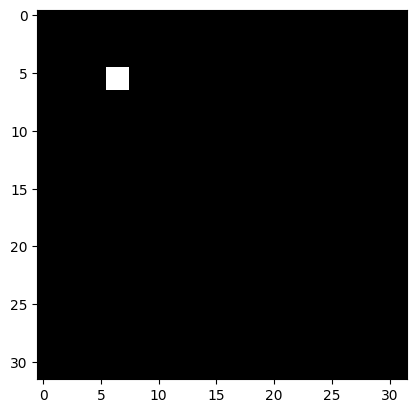

In [469]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
plt.imshow(img,cmap='gray')

amp, n = qpie_encoding(img)
print(n)
SHOTS = 1048576
dev = qml.device('default.qubit', wires=n, shots=SHOTS)

In [470]:
@qml.qnode(dev)
def circuit(init_value, num_wire):
    qml.QubitStateVector(init_value, wires=range(num_wire))
    return qml.probs()

C:\Users\Kuift\AppData\Local\Temp\ipykernel_19952\2291248903.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


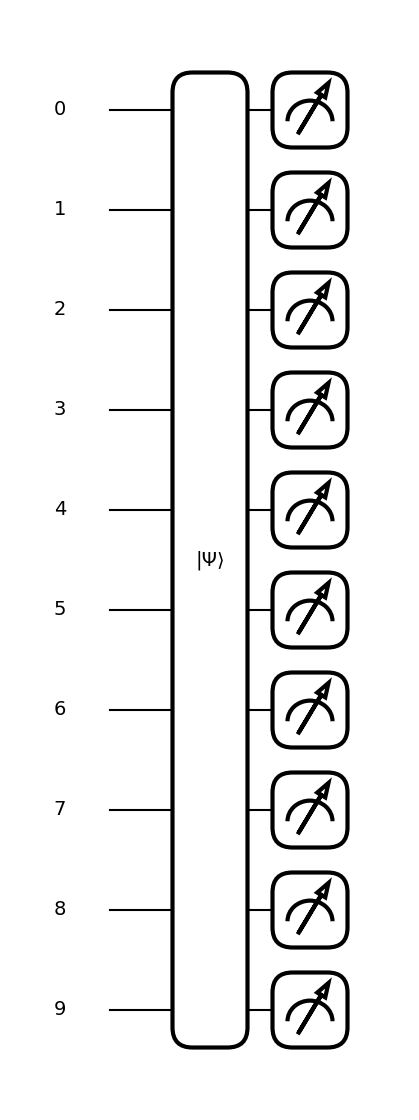

In [471]:
fig, ax = qml.draw_mpl(circuit)(amp,n)
fig.show()


In [472]:
measured_circuit = circuit(amp,n)

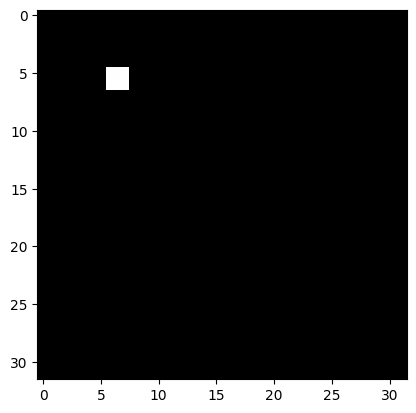

In [473]:
norm = (np.linalg.norm(img.flatten()))
imout = measured_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

In [474]:
def MSE(img1,img2):

    img = (img1-img2)**2
    s = np.sum(img.flatten())/(len(img1**2))

    return s

In [475]:
MSE(img,imout)

0.07031252429516144

10
[4.00487984 4.04612083 3.89059362 ... 3.88506757 3.93849194 4.00683011]


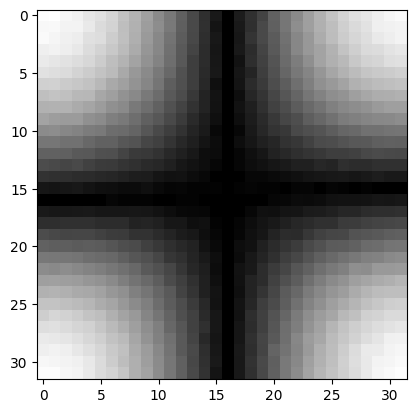

In [476]:
@qml.qnode(dev)
def qft_circuit(init_value,num_wire):
    qml.QubitStateVector(init_value, wires=range(num_wire))
    print(num_wire)
    #qml.QFT(wires=[i for i in range(int(num_wire/2))])
    #qml.QFT(wires=[i+int(num_wire/2) for i in range(int(num_wire/2))])
    qml.QFT(wires=range(num_wire))
    # qml.QFT(wires=range(num_wire))
    #qml.adjoint(qml.QFT(wires=range(num_wire)))
    return qml.probs()

measured_qft_circuit = np.sqrt(qft_circuit(amp,n)) * norm * 2**(n/2)
print(measured_qft_circuit)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

10


C:\Users\Kuift\AppData\Local\Temp\ipykernel_19952\2016479167.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


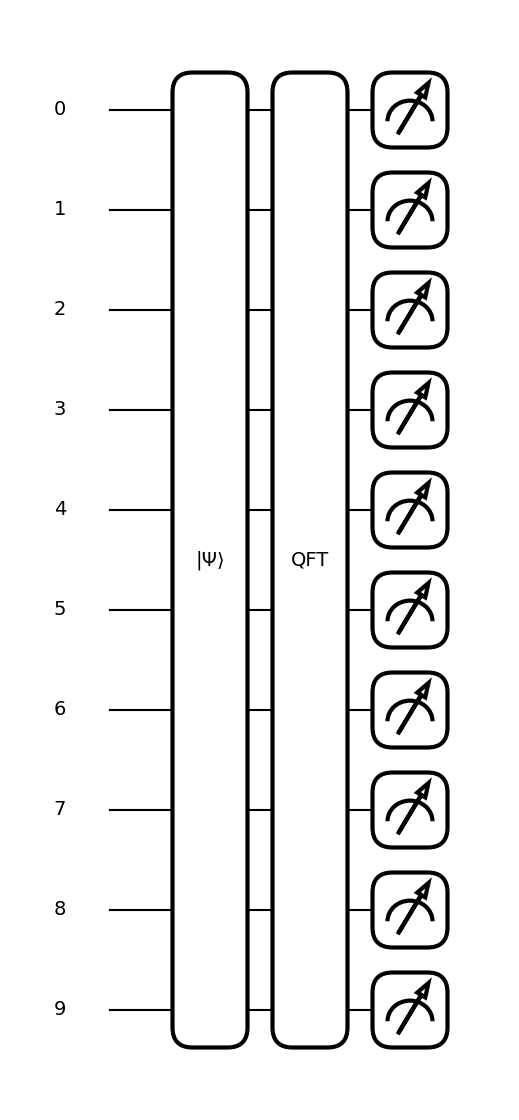

In [477]:
fig, ax = qml.draw_mpl(qft_circuit)(amp,n)
fig.show()

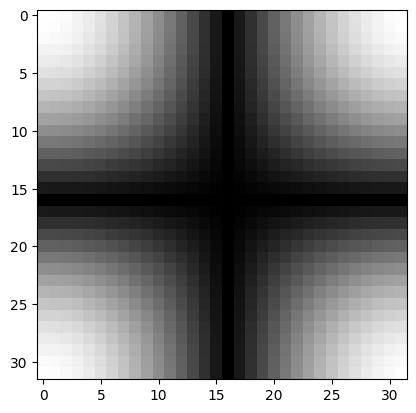

In [478]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [479]:
MSE(imout,np.abs(ft))

0.46959921709963065

10


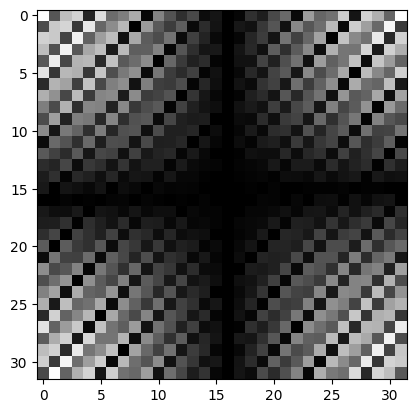

In [480]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
img[24,25] = 1
img[25,25] = 1
img[24,26] = 1
img[25,26] = 1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n)) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

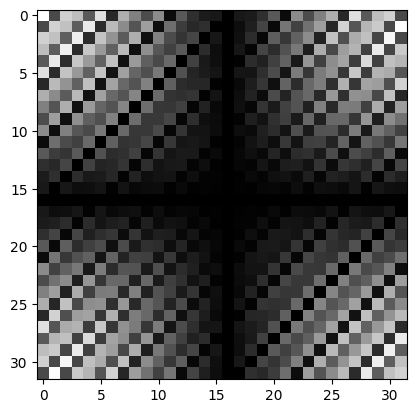

In [481]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [482]:
MSE(imout,np.abs(ft))

96.8876933446611

10


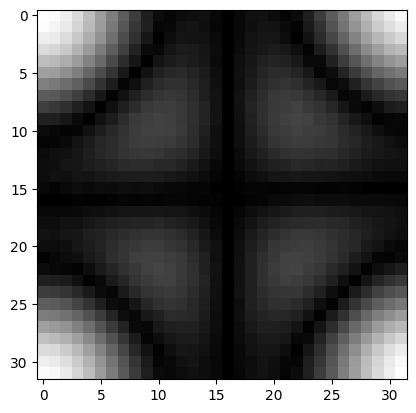

In [483]:
img = np.zeros((32,32))
img[4,4]=1
img[4,5]=1
img[5,4]=1
img[5,5]=1
img[6,4]=1
img[6,5]=1
img[7,4]=1
img[7,5]=1
img[5,3]=1
img[6,3]=1
img[5,5]=1
img[6,6]=1
img[5,6]=1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n)) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

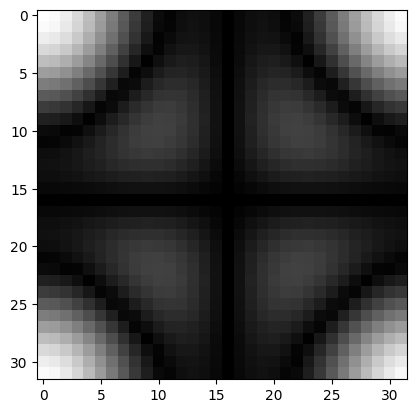

In [484]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [485]:
MSE(imout,np.abs(ft))

4.717688232662272

In [486]:
img = np.zeros((64,64))
img[10:14,10:18] =1
img[9,11:17]=1
img[8,12:16]=1
img[14,11:17]=1
img[15,12:16]=1
amp, n = qpie_encoding(img)
print(n)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n)) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

12


ValueError: State vector must have shape (2**wires,) or (batch_size, 2**wires).